Metody rozpoznawania obrazów - zadanie 4

**Piotr Zawiślan**

**Zalewamy wrzątkiem chińską zupkę, czyli tym razem nasza sieć przygotowana jest z użyciem gotowej bazy**

W poprzednim zadaniu korzystaliśmy z nieźle przygotowanego (oraz przede wszystkim bardzo dużego) zbioru danych CIFAR10. W praktyce zwykle nie dysponujemy takimi zasobami. Zasymulujemy tą sytuację pobierając zdjęcia z popularnej wyszukiwarki. Będzie ich niewiele (kilkaset) i będą bardzo nierównej jakości. W związku z tym trening oparty o tak mały zbiorek nie będzie zbyt efektywny - będziemy się więc posiłkować pre-treningiem z użyciem innych danych (a nawet "pożyczeniem" wstępnie wytrenowanej sieci). A tak w rzeczywistości jest to (znów!) pretekst by pobawić się kolejnymi mechanizmami związanymi z przetwarzaniem obrazów (zapisywanie i wczytywanie modeli, fine-tuning, obsługa zewnętrznych zbiorów danych, etc.).

- W przypadku punktów oznaczonych ikoną ⌨️ poinformuj w jaki sposób je zrealizowałeś - wspomnij kluczowe klasy/metody/funkcje lub załącz powiązany fragment kodu źródłowego.
- W przypadku punktów oznaczonych ikoną 🖼️ załącz w raporcie obraz przedstawiający efekt danej operacji.
- W przypadku punktów oznaczonych ikoną 📈 załącz w raporcie wykres przedstawiający trendy optymalizacji (uczenia) dla danych treningowych i testowych. W tym przypadku - jak zmieniała się skuteczność klasyfikacji (accuracy) i funkcja straty (loss).


In [1]:
import numpy as np
import pandas as pd
import torch
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
from pathlib import Path

In [2]:
torch.cuda.is_available()

True

In [3]:
np.random.seed(311)

PLOTS_PATH = os.path.join(".", "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(PLOTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
def plot_image(image: torch.Tensor, title=None, save=False, fig_id=None, cmap='gray'):
    ndim = np.array(image.detach()).ndim
    if ndim == 2:
        plt.imshow(image.detach().numpy(), cmap=cmap)
    elif ndim == 3:
        if image.shape[0] == 1:
            plt.imshow(image[0].detach().numpy(), cmap=cmap)
        else:
            plt.imshow(np.moveaxis(image.detach().numpy(), 0, -1))
    else:
        return
    if title:
        plt.title(title)
    plt.axis("off")
    if save and fig_id is not None:
        save_fig(fig_id)
    plt.show()

Kod z `zadania 3`:

In [6]:
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [8]:
class Trainer:
    """Training manager for a given model"""

    def __init__(self, model: nn.Module, train_ds: Dataset, val_ds: Dataset, device=None,
                 batch_size=50, lr=0.001, momentum=0.9):
        
        # device
        if device is None or device == 'cuda':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else: 
            self.device = 'cpu'
        
        # model, dataloaders, loss, optimizer
        self.model = model.to(self.device)
        self.batch_size = batch_size
        self.train_dataloader = DataLoader(train_ds, batch_size=batch_size, 
                                           shuffle=True, drop_last=True)
        self.val_dataloader = DataLoader(val_ds, batch_size=batch_size, 
                                         shuffle=True, drop_last=True)
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, self.model.parameters()),
                                         lr=lr, 
                                         momentum=momentum)
            
        # early stopping
        self._early_stopper: EarlyStopper = EarlyStopper(patience=4, min_delta=0.1)
        self.early_stopped = False
        self.early_stopped_model = self.model
        
        # training history (average for one epoch)
        self._train_loss_hist = []
        self._train_acc_hist = []
        self._val_loss_hist = []
        self._val_acc_hist = []
        self.train_time_hist = []

        
    def train_step(self) -> tuple[float, float, float]:
        """Returns avg_train_loss, avg_train_acc, epoch_train_time"""
        num_batches = len(self.train_dataloader)
        epoch_loss = 0.
        epoch_correct_preds = 0
        self.model.train()
        t_start = perf_counter()
        for batch, (X, y) in enumerate(self.train_dataloader):
            X, y = X.float().to(self.device), y.float().to(self.device)
            self.optimizer.zero_grad()
            prediction = self.model(X)
            assert prediction.shape == y.shape, \
                f"prediction [{prediction.shape}] and y [{y.shape}] shapes does not match"
            loss = self.loss_function(prediction, y)
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
            correct_preds = (prediction.argmax(dim=1) == y.argmax(dim=1)).count_nonzero().item()
            epoch_correct_preds += correct_preds
            
        t_end = perf_counter()
        epoch_train_time = t_end - t_start
        self.train_time_hist.append(epoch_train_time)
        epoch_avg_loss = epoch_loss / num_batches
        epoch_avg_acc = epoch_correct_preds / (num_batches * self.batch_size)
        self._train_loss_hist.append(epoch_avg_loss)
        self._train_acc_hist.append(epoch_avg_acc)
        
        return epoch_avg_loss, epoch_avg_acc, epoch_train_time
        

    def val_step(self) -> tuple[float, float]:
        """Returns avg_val_loss, avg_val_acc"""
        num_batches = len(self.val_dataloader)
        epoch_loss = 0.
        epoch_correct_preds = 0
        self.model.eval()
        with torch.no_grad():
            for batch, (X, y) in enumerate(self.val_dataloader):
                X, y = X.float().to(self.device), y.float().to(self.device)
                prediction = self.model(X)
                assert prediction.shape == y.shape, \
                    f"prediction [{prediction.shape}] and y [{y.shape}] shapes does not match"
                loss = self.loss_function(prediction, y)
                epoch_loss += loss.item()
                correct_preds = (prediction.argmax(dim=1) == y.argmax(dim=1)).count_nonzero().item()
                epoch_correct_preds += correct_preds
            
            epoch_avg_loss = epoch_loss / num_batches
            epoch_avg_acc = epoch_correct_preds / (num_batches * self.batch_size)
            self._val_loss_hist.append(epoch_avg_loss)
            self._val_acc_hist.append(epoch_avg_acc)
            
            if not self.early_stopped:
                if self._early_stopper.early_stop(epoch_avg_loss):
                    self.early_stopped_model = self.model.__class__()
                    self.early_stopped_model.load_state_dict(self.model.state_dict())
                    self.early_stopped = True
                    print("Early stopped model saved")
            
            return epoch_avg_loss, epoch_avg_acc


    def get_loss_acc_time_history(self) -> \
        tuple[list[float], list[float], list[float], list[float], list[float]]:
        """Returns avg_train_loss_list, avg_train_acc_list, 
            avg_val_loss_list, avg_val_acc_list"""
        return self._train_loss_hist, self._train_acc_hist, \
                self._val_loss_hist, self._val_acc_hist, self.train_time_hist

In [9]:
LOSS_Y_LIM = (0., 2.5)
TIME_Y_LIM = (0., 30.)

def plot_train_stats(train_loss_list, train_acc_list, val_loss_list, val_acc_list, train_time_list,
                     fig_id=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.subplots_adjust(hspace=0.4)
    fig.set_size_inches(12, 12)
    
    epochs_range = np.arange(0, len(train_loss_list))
    
    # Loss
    ax1.plot(epochs_range, train_loss_list, 'y.', label='train')
    ax1.plot(epochs_range, val_loss_list, 'c-', label='val')
    ax1.set_title("Loss")
    ax1.set_ylim(*LOSS_Y_LIM)
    ax1.grid()
    ax1.legend()
    
    # Accuracy
    ax2.plot(epochs_range, train_acc_list, 'b.', label='train')
    ax2.plot(epochs_range, val_acc_list, 'm-', label='val')
    ax2.set_title("Accuracy")
    ax2.set_ylim(-0.1, 1.1)
    ax2.grid()
    ax2.legend()
    
    # Time
    ax3.plot(epochs_range, train_time_list, 'g--')
    ax3.set_title("Training time")
    ax3.set_ylim(*TIME_Y_LIM)
    ax3.set_xlabel("epochs")
    ax3.grid()
    
    if fig_id is not None:
        save_fig(fig_id)
    plt.show()

In [10]:
from torch import nn
from typing import Literal, Union

def get_conv_block(
    in_ch: int, mid_ch: int, out_ch: int, 
    kernel_a_size: int = 3, kernel_b_size: int = 3, 
    pool_size: int = 2, activation_func_str: Literal['relu', 'sigmoid'] = 'relu',
    batch_norm: bool = False,
    dropout_rate: Union[float, None] = None):
    
    if activation_func_str == 'relu':
        activation_func = nn.ReLU
    elif activation_func_str == 'sigmoid':
        activation_func = nn.Sigmoid
    else:
        raise ValueError("No such activation func to choose.")
        
    seq_conv_1 = [
        nn.Conv2d(
            in_channels=in_ch, out_channels=mid_ch, 
            kernel_size=kernel_a_size, stride=1, padding='same'),
        activation_func()
    ]
    
    seq_conv_2 = [
        nn.Conv2d(
            in_channels=mid_ch, out_channels=out_ch, 
            kernel_size=kernel_b_size, stride=1, padding='same'),
        activation_func()
    ]
    
    if batch_norm:
        seq_conv_1.append(nn.BatchNorm2d(num_features=mid_ch))
        seq_conv_2.append(nn.BatchNorm2d(num_features=out_ch))
    
    seq_max_pool = [
        nn.MaxPool2d(kernel_size=pool_size)
    ]
    
    if dropout_rate is not None:
        seq_max_pool.append(nn.Dropout(p=dropout_rate))
    
    return nn.Sequential(*seq_conv_1, *seq_conv_2, *seq_max_pool)

In [11]:
def get_acc_loss(model: nn.Module, test_ds: Dataset, batch_size=64) -> tuple[float, float]:
    test_data_loader = DataLoader(test_ds, batch_size=batch_size,
                                  shuffle=True, drop_last=True)
    num_batches = len(test_data_loader)
    epoch_loss = 0.
    epoch_correct_preds = 0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    loss_function = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(test_data_loader):
            X, y = X.float().to(device), y.float().to(device)
            prediction = model(X)
            assert prediction.shape == y.shape, \
                f"prediction ({prediction.shape}) and y ({y.shape}) shapes does not match"
            loss = loss_function(prediction, y)
            epoch_loss += loss.item()
            correct_preds = (prediction.argmax(dim=1) == y.argmax(dim=1)).count_nonzero().item()
            epoch_correct_preds += correct_preds

        epoch_avg_loss = epoch_loss / num_batches
        epoch_avg_acc = epoch_correct_preds / (num_batches * batch_size)

        return epoch_avg_acc, epoch_avg_loss

# Kaczko, kaczko, idź!

Pierwszym krokiem będzie przygotowanie nowego, zindywidualizowanego zbioru danych. W tym celu skorzystamy z małej biblioteczki umożliwiającej szybkie pobieranie takich danych z wyszukiwarki DuckDuckGo: jmd_imagescraper .
1. Pobierz kilkaset (maksimum to aktualnie 1000 - staramy się dążyć do tej liczby) obrazów należących do 3 różnych klas. 
    1. Postaraj się by klasy były ciekawe/nieoczywiste (prowadzący korzystał z zestawu [zielone curry/spaghetti carbonara/ciasto marchewkowe]).
    2. Upewnij się, że żadna z tych klas nie występuje w zbiorze CIFAR, ani w zbiorze ImageNet (https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) - w przeciwnym wypadku wyniki będą wypaczone.
    3. Przejrzyj pobrane obrazy, usuń najbardziej rażące przykłady niewłaściwej zawartości (nie spędź na tym zbyt dużo czasu! ;]).
2. Wczytaj obrazy z dysku tworząc nowy, prywatny zbiór danych.
    1. Twoja ulubiona biblioteka do operacji tensorowych i uczenia maszynowego prawdopodobnie oferuje gotowe klasy i metody pomocnicze! [⌨️]
    2. Zapewnij wstępne przeskalowanie obrazów do rozmiaru 32x32 (to bardzo agresywne i trochę sztuczne obniżenie rozdzielczości, ale ułatwi nam wykonanie początkowych etapów zadania).
    3. Podziel zbiór na część treningową i walidacyjną w proporcjach 80%-20%. [⌨️]
    4. Wyplotuj kilka elementów ze zbioru treningowego wraz z ich etykietami by upewnić się, że wszystko działa zgodnie z intencjami. [🖼️]

In [19]:
from jmd_imagescraper.core import duckduckgo_search
from jmd_imagescraper.imagecleaner import display_image_cleaner

In [20]:
image_root = Path().cwd() / 'data' / 'scraped'

In [29]:
# sailboat
duckduckgo_search(image_root, 'sailboat', "sailboat", max_results=400)

Duckduckgo search: sailboat


[WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/001_c3c87547.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/002_7d3450fd.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/003_c56c150d.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/004_066eacaf.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/005_bca73d9a.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/006_cf5a089f.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/007_43ded0d5.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/008_f9d1377a.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/sailboat/sailboat/009_a569be60.jpg'),
 WindowsPath('C:/Dane/Projek

In [28]:
# motor yacht
duckduckgo_search(image_root, 'motor_yacht', "motor yacht", max_results=400)

Duckduckgo search: motor yacht


[WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/001_c1762a79.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/002_c51abd00.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/003_61b13abc.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/004_bf0b698a.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/005_b75f20b9.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/006_b11e3003.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/007_b3711f41.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/008_2eb2d046.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/009_50fa7394.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/motor_yacht/

In [26]:
# catamaran sailboat
duckduckgo_search(image_root, 'catamaran', "catamaran sailboat", max_results=400)

Duckduckgo search: catamaran sailboat


[WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/001_91a76de1.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/002_f8a4f0dd.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/003_66abbcad.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/004_d0351afd.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/005_62a5e668.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/006_50794209.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/007_134185b5.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/008_bef31ff9.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/009_54d10dae.jpg'),
 WindowsPath('C:/Dane/Projekty_studia/MRO_2022/mro_zad_4/data/scraped/catamaran/010_126aadcb.jpg'),


In [12]:
class_int_dict = {'catamaran': 0, 'motor_yacht': 1, 'sailboat': 2}
int_class_dict = {v: k for k, v in class_int_dict.items()}

In [155]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Lambda
from torchvision.transforms.functional import resize
from torchvision.io import read_image

height, width = 32, 32

image_folder = ImageFolder(
    root=str(image_root),
    transform=Lambda(lambda X: resize(img=ToTensor()(X), size=(height, width))),
    target_transform=Lambda(
        lambda y: torch.zeros(3, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

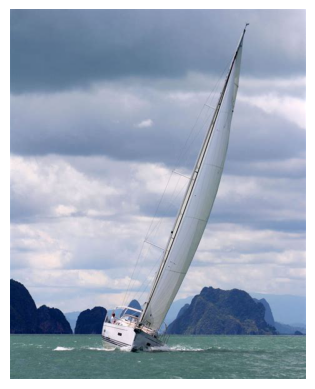

In [144]:
plot_image(read_image(path=str(image_root / 'sailboat' / '016_87d81eef.jpg')))

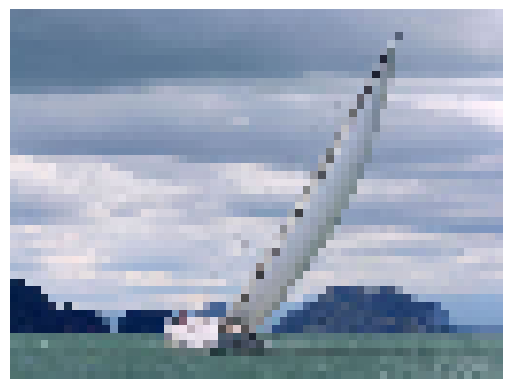

In [145]:
test_transform = Lambda(lambda X: resize(img=X, size=(48, 64)))

res = test_transform(read_image(path=str(image_root / 'sailboat' / '016_87d81eef.jpg')))

plot_image(res)

In [156]:
from torch.utils.data import random_split

train_boats_ds, test_boats_ds = random_split(dataset=image_folder, lengths=(500, 100))

sailboat


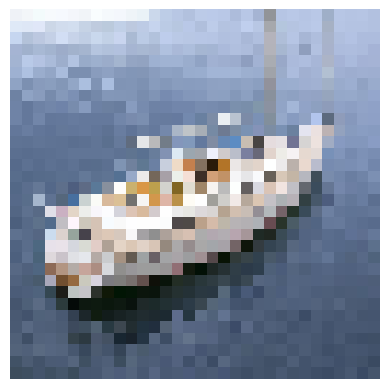

motor_yacht


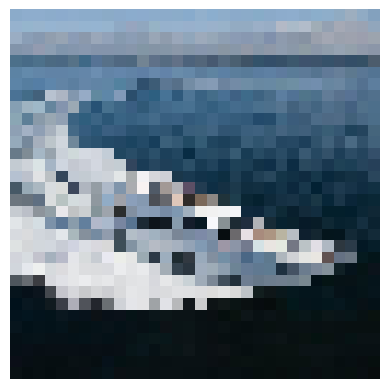

sailboat


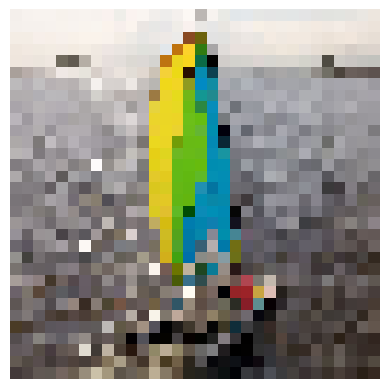

motor_yacht


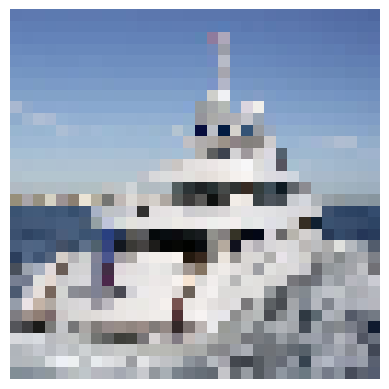

catamaran


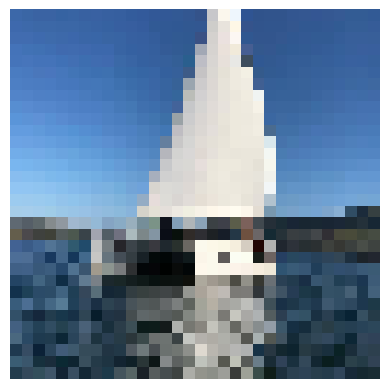

sailboat


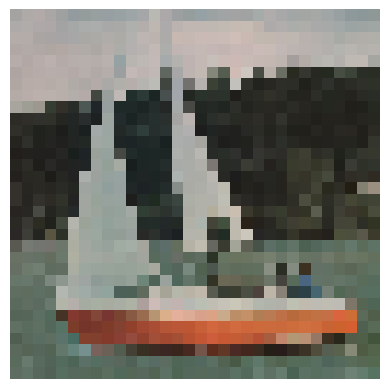

In [175]:
for i, (X, y) in enumerate(DataLoader(train_boats_ds)):
    if i == 6:
        break
    print(int_class_dict[y.argmax().item()])
    plot_image(X.squeeze(0))

# Sieci konwolucyjne na bazie gotowej kostki rosołowej

3. Zacznijmy klasycznie. Skorzystajmy z najlepszej architektury spośród tych używanych w Zadaniu 03 i wytrenujmy jej parametry (od zera) na naszym świeżo przygotowanym zbiorze. Jaki efekt udaje się uzyskać? [📈]
    1. Pamiętaj by zmienić liczbę wyjść z ostatniej warstwy tak, by pasowała do nowej liczby klas!


In [160]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            get_conv_block(in_ch=3, mid_ch=20, out_ch=20, batch_norm=True, dropout_rate=0.1),
            get_conv_block(in_ch=20, mid_ch=40, out_ch=40, batch_norm=True, dropout_rate=0.2),
            get_conv_block(in_ch=40, mid_ch=80, out_ch=80, batch_norm=True, dropout_rate=0.3),
            get_conv_block(in_ch=80, mid_ch=160, out_ch=160, batch_norm=True, dropout_rate=0.4),
            nn.Flatten(),
            nn.Linear(in_features=160*(32 // 16)**2, out_features=3),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

In [161]:
trainer_3 = Trainer(
    model=Model3(),
    train_ds=train_boats_ds,
    val_ds=test_boats_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 120

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_3.train_step()
    avg_val_loss, avg_val_acc = trainer_3.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.392 loss: 1.094 train_time: 3.42 s
Val | acc: 0.430 loss: 1.089
================ epoch 010 ================
Train | acc: 0.636 loss: 0.901 train_time: 3.22 s
Val | acc: 0.630 loss: 0.893
================ epoch 020 ================
Train | acc: 0.752 loss: 0.814 train_time: 3.46 s
Val | acc: 0.670 loss: 0.874
================ epoch 030 ================
Train | acc: 0.806 loss: 0.745 train_time: 3.98 s
Val | acc: 0.640 loss: 0.907
================ epoch 040 ================
Train | acc: 0.882 loss: 0.679 train_time: 4.40 s
Val | acc: 0.640 loss: 0.884
================ epoch 050 ================
Train | acc: 0.926 loss: 0.639 train_time: 3.67 s
Val | acc: 0.660 loss: 0.882
================ epoch 060 ================
Train | acc: 0.952 loss: 0.608 train_time: 3.61 s
Val | acc: 0.660 loss: 0.872
================ epoch 070 ================
Train | acc: 0.954 loss: 0.602 train_time: 3.57 s
Val | acc: 0.700 loss: 0.844
================

Saving figure model_stats_3


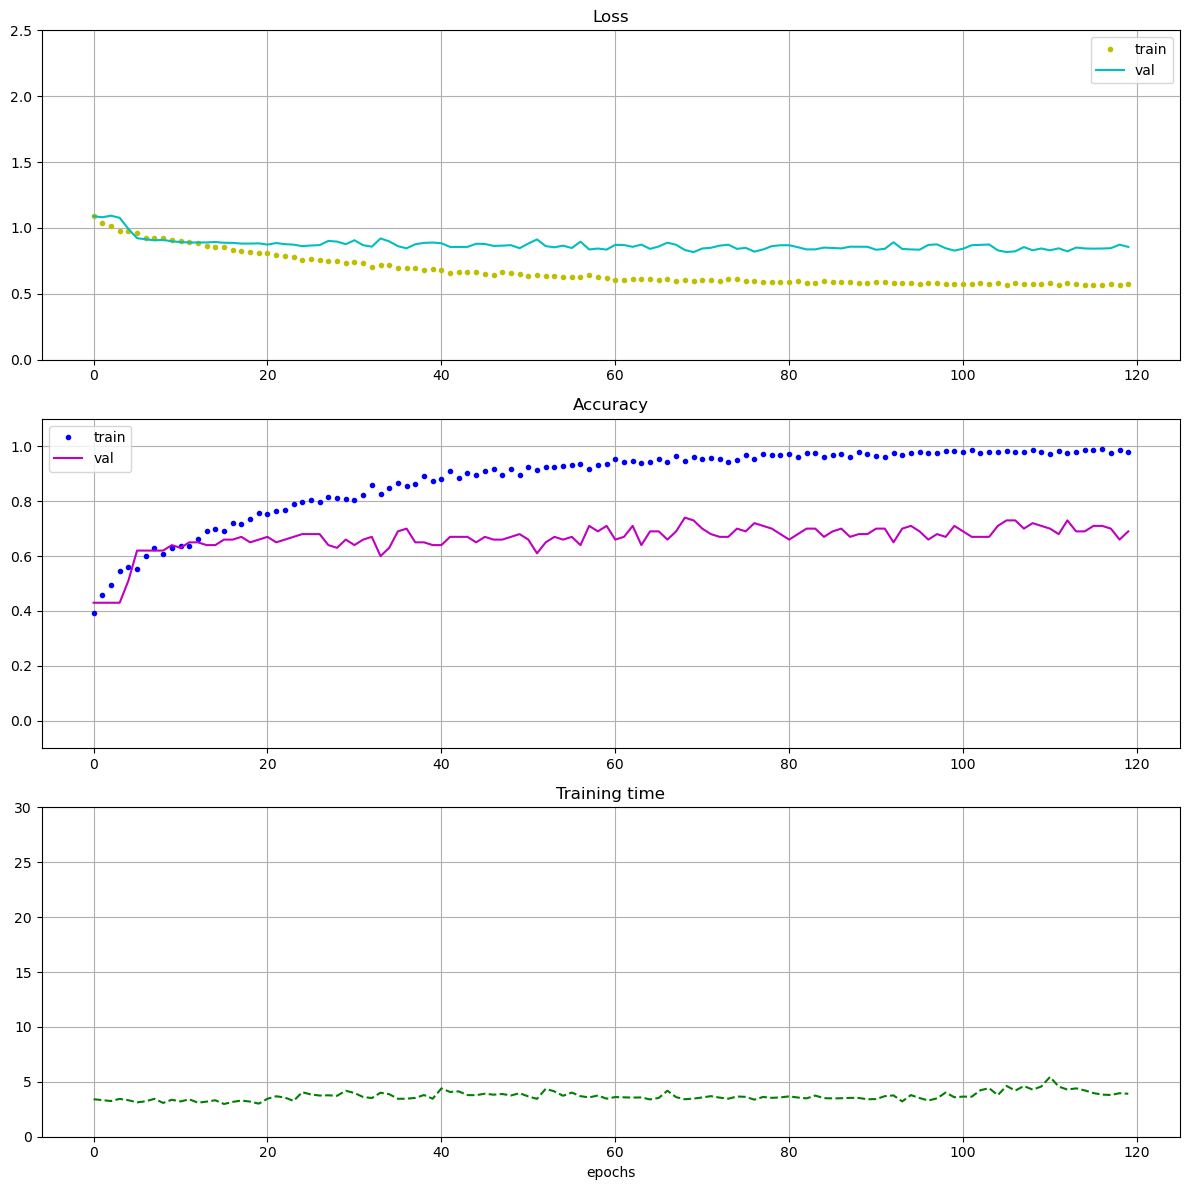

In [162]:
plot_train_stats(*trainer_3.get_loss_acc_time_history(), fig_id='model_stats_3')

In [167]:
example_X, example_y = next(iter(DataLoader(test_boats_ds)))

In [168]:
trainer_3.model(example_X.to('cuda'))

tensor([[9.8497e-05, 9.9086e-01, 9.0408e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [169]:
example_y

tensor([[0., 1., 0.]])

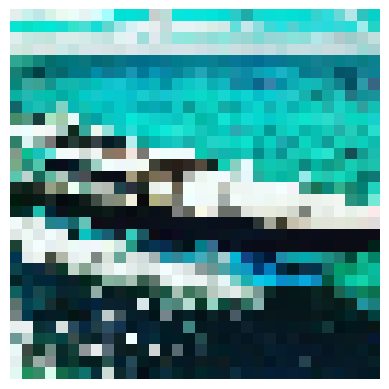

In [171]:
plot_image(example_X.squeeze(0))

4. Teraz zrobimy pierwsze podejście do tzw. transfer learning. Wiele zbiorów danych składa się z elementów podobnego typu (np. realistycznych fotografii). To z kolei oznacza, że filtry konwolucyjne znalezione na skutek dopasowania parametrów do jednego zbioru danych (zwykle dużego i dobrej jakości, jak wcześniej używany CIFAR) często świetnie nadają się (z ewentualnie drobnymi korektami) do przetwarzania innego zbioru (np. tego zebranego na DuckDuckGo).
    1. Wczytaj zapisany wcześniej model, który został dopasowany do problemu z Zadania 03 (skutecznie klasyfikuje elementy zbioru CIFAR).
        1. Jeżeli zapomnieliśmy go zapisać, to niestety konieczne jest powtórzenie treningu (oczywiście tylko finalnej, najbardziej efektywnej aranżacji sieci).
    2. Zamroź wszystkie jego wagi, tak by nie zmieniały się w trakcie uczenia.
        1. Powinna to umożliwiać używana biblioteka. [⌨️]
    3. Upewnij się, że wykorzystywane warstwy typu batch normalisation pracują w trybie inferencji - czyli po prostu nie będą zmieniać ustalonych już oszacowań średniej i wariancji poszczególnych cech (w przeciwnym wypadku mogłyby zupełnie zepsuć efekty pre-treningu).
        1. To też wspiera biblioteka, realizacja jest często powiązana z poprzednim punktem. [⌨️]
    4. Usuń z modelu ostatnią, gęsto połączoną warstwę (tą służącą do klasyfikacji). [⌨️]
    5. Zamiast usuniętej warstwy dodaj nową, jeszcze niewytrenowaną.
        1. Jej wagi nie powinny być zamrożone - powinny móc się zmieniać! [⌨️]
    6. Wytrenuj na nowym zbiorze danych taką "pożyczoną sieć" (większość parametrów została już wstępnie ustalona dla poprzedniego zbioru, jedynie ostatnia gęsta warstwa jest trenowana "od zera"). Jak teraz wypadają wyniki? [📈]

In [212]:
model_z3_150_state_dict = torch.load(Path.cwd() / 'models' / 'model_G_150_sd.pt')

In [213]:
class CNNModelG(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            get_conv_block(in_ch=3, mid_ch=20, out_ch=20, batch_norm=True, dropout_rate=0.1),
            get_conv_block(in_ch=20, mid_ch=40, out_ch=40, batch_norm=True, dropout_rate=0.2),
            get_conv_block(in_ch=40, mid_ch=80, out_ch=80, batch_norm=True, dropout_rate=0.3),
            get_conv_block(in_ch=80, mid_ch=160, out_ch=160, batch_norm=True, dropout_rate=0.4),
            nn.Flatten(),
            nn.Linear(in_features=160*(32 // 16)**2, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        probs = self.sequence(x)
        return probs

In [214]:
model_z3 = CNNModelG()
model_z3.load_state_dict(model_z3_150_state_dict)

<All keys matched successfully>

In [215]:
# freeze model params
model_z3.requires_grad_(False)
# evaluation mode
model_z3.eval()

CNNModelG(
  (sequence): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding

In [216]:
# swap linear layers
list(model_z3.children())[0][-2] = nn.Linear(in_features=640, out_features=3, bias=True)
list(model_z3.children())[0][-1] = nn.Softmax(dim=1)

In [ ]:
# filter(lambda p: p.requires_grad, model.parameters())

In [217]:
ex_param_val = list(model_z3.parameters())[0][0, 0, 0, 0].item()

In [219]:
ex_param_val

-0.09421845525503159

In [218]:
for p in model_z3.parameters():
    if p.requires_grad:
        print(p)

Parameter containing:
tensor([[-0.0298, -0.0193, -0.0306,  ...,  0.0162,  0.0019,  0.0366],
        [ 0.0027,  0.0071, -0.0194,  ...,  0.0335,  0.0248, -0.0390],
        [ 0.0101, -0.0195,  0.0349,  ...,  0.0235,  0.0289, -0.0380]],
       requires_grad=True)
Parameter containing:
tensor([-0.0216, -0.0207, -0.0288], requires_grad=True)


In [220]:
# model_tl3
trainer_tl_3 = Trainer(
    model=model_z3,
    train_ds=train_boats_ds,
    val_ds=test_boats_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 60

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_tl_3.train_step()
    avg_val_loss, avg_val_acc = trainer_tl_3.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.318 loss: 1.146 train_time: 2.88 s
Val | acc: 0.310 loss: 1.133
================ epoch 010 ================
Train | acc: 0.634 loss: 0.912 train_time: 3.04 s
Val | acc: 0.580 loss: 0.945
================ epoch 020 ================
Train | acc: 0.694 loss: 0.855 train_time: 2.98 s
Val | acc: 0.640 loss: 0.915
================ epoch 030 ================
Train | acc: 0.702 loss: 0.845 train_time: 2.93 s
Val | acc: 0.690 loss: 0.889
================ epoch 040 ================
Train | acc: 0.736 loss: 0.817 train_time: 2.77 s
Val | acc: 0.690 loss: 0.882
================ epoch 050 ================
Train | acc: 0.754 loss: 0.806 train_time: 2.92 s
Val | acc: 0.690 loss: 0.881
================ training ended ================
Train | acc: 0.748 loss: 0.804 train_time: 2.67 s
Val | acc: 0.660 loss: 0.878


Saving figure model_stats_tl_3


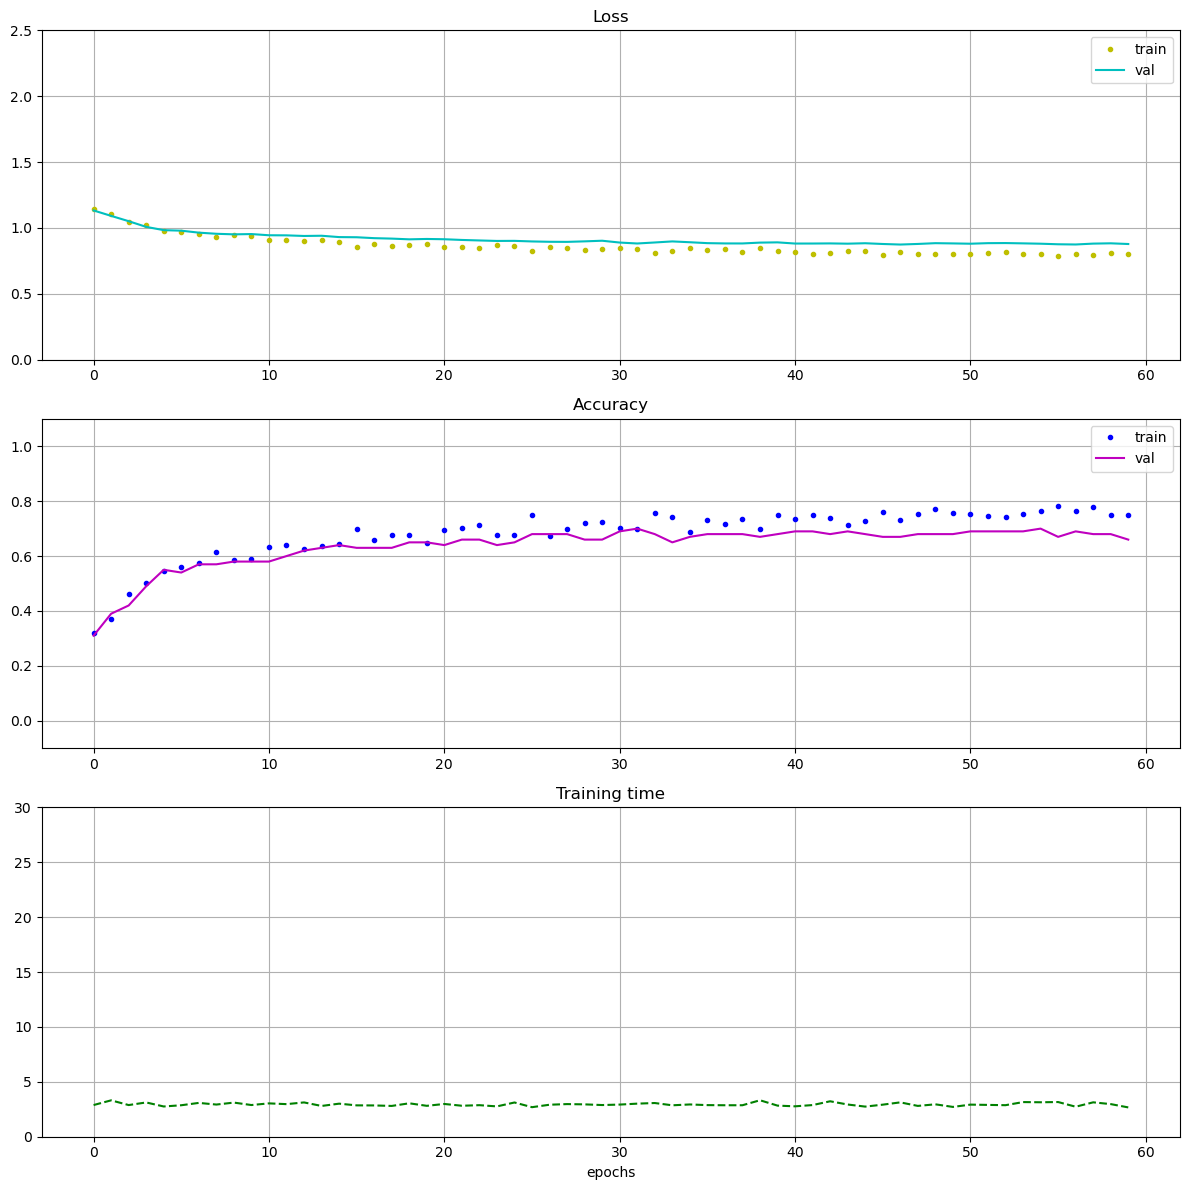

In [221]:
plot_train_stats(*trainer_tl_3.get_loss_acc_time_history(), fig_id='model_stats_tl_3')

In [224]:
ex_param_val

-0.09421845525503159

In [225]:
list(trainer_tl_3.model.parameters())[0][0, 0, 0, 0].item()

-0.09421845525503159

5. Dla naszego nowego zbioru danych to może być jednak za mało (w końcu bazowa sieć radziła sobie z CIFARem tylko przyzwoicie - ale daleko jej było do rekordów)! Powtórzymy więc ten manewr, ale wykorzystując jako bazę sieć, która była trenowana na znacznie większym i bardziej różnorodnym zbiorze (np. na legendarnym ImageNet - https://www.image-net.org/index.php - być może najważniejszym zestawie danych treningowych w całej historii współczesnego rozpoznawania obrazów). A najlepiej taką sieć, która ma sprawdzoną architekturę i osiągała już wcześniej sukcesy.
    1. Zwiększmy wejściowy rozmiar obrazów z 32x32 do 256x256 - nowa sieć bazowa pozwoli nam na efektywne wykorzystywanie tak dużych obserwacji.
    2. Na potrzeby tego zadania skorzystamy z sieci Xception, zaprezentowanej pierwszy raz na CVPR2017.
        1. Ciekawi szczegółów mogą poczytaj o niej więcej tutaj: https://arxiv.org/abs/1610.02357 (była to głęboka sieć z połączeniami residualnymi i sprytną realizacją konwolucji, która dzieli ich obliczanie na dwa niezależne etapy).
        2. Trzeba zdobyć (pobrać) gotowy model, a w szczególności gotowe wartości parametrów.
            1. Jeżeli używamy TensorFlow, to można go dorwać choćby tu: https://keras.io/api/applications/xception/ .
            2. Użytkownicy PyTorcha znajdą odpowiedni model np. tutaj: https://github.com/Cadene/pretrained-models.pytorch#xception. Jeżeli to za dużo ambarasu, to można skorzystać z dowolnego zamiennika z https://pytorch.org/vision/stable/models.html - byleby używany model kończył się GAPem.
        3. Usuńmy z pobranego modelu wszyskie warstwy od GAP wzwyż (czyli sam GAP i wszystko co po nim).
            1. Używany framework zwykle mocno pomaga w takich operacjach.
        4. Dopilnujmy, by jego wagi były zamrożone, a wszelkie moduły normalizacyjne nie zmieniały swoich estymat. Upewnijmy się też, że jest gotowy na wejście w rozmiarze 256x256x3.
        5. Wykorzystajmy go zamiast sieci z Zadania 03 do stworzenia nowego klasyfikatora.
            1. Potok przetwarzania powinien wyglądać mniej-więcej tak: wejście -> Xception ["zamrożone" wagi, usunięte końcowe warstwy] -> GAP -> warstwa gęsto połączona [zupełnie nowa, w pełni gotowa do treningu] -> wyjście . [⌨️]
    3. Wytrenujmy taki klasyfikator (a właściwie jego ostatnią warstwę). Powinno wystarczyć co najwyżej kilkadziesiąt epok. Jakie tym razem uzyskaliśmy efekty? Zapiszmy gdzieś stan sieci na koniec treningu. [📈]
    4. Ten wynik da się jeszcze zwykle odrobinę poprawić, stosując tzw. fine-tuning - korektę pobranych gotowych wag tak, by pasowały do naszego problemu.
        1. Wczytajmy ponownie sieć z poprzedniego punktu. "Rozmroźmy" wagi wszystkich jej warstw, umożliwiając im teraz ewolucję w czasie uczenia. [⌨️]
        2. Mimo to, dopilnujmy by ewentualne batch normalisation nadal były w trybie inferencji! Zmiany zaszytych wewnątrz nich estymat mogłyby kompletnie zniszczyć wszystkie efekty dotychczasowego uczenia! W efekcie batch normalisation będą w ciekawym stanie "pośrednim" - wagi odpowiedzialne za skalowanie wyników będą mogły się zmieniać, ale wykorzystywane wartości średniej i wariancji już nie. [⌨️]
        3. Zmniejsz prędkość uczenia się (learning rate lub podobny parametr) - nawet 10- krotnie! Będziemy przecież robić tylko drobne korekty.


4. Puść dodatkowe kilkanaście-kilkadziesiąt epok takiego powolnego douczania. Czy udało się wycisnąć z modelu jeszcze trochę efektywności? Zapisz gdzieś wynikowy model (przyda się w ostatniej sekcji). [📈]

In [12]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Lambda
from torchvision.transforms.functional import resize
from torchvision.io import read_image

height, width = 256, 256

image_root = Path().cwd() / 'data' / 'scraped'

image_folder_large = ImageFolder(
    root=str(image_root),
    transform=Lambda(lambda X: resize(img=ToTensor()(X), size=(height, width))),
    target_transform=Lambda(
        lambda y: torch.zeros(3, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

In [13]:
class_int_dict = {'catamaran': 0, 'motor_yacht': 1, 'sailboat': 2}
int_class_dict = {v: k for k, v in class_int_dict.items()}

motor_yacht


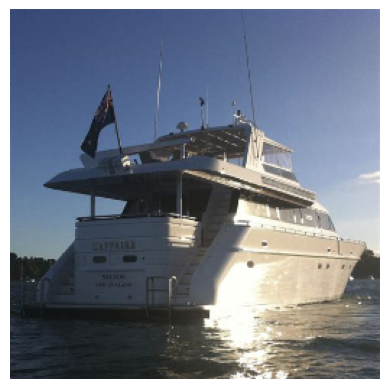

sailboat


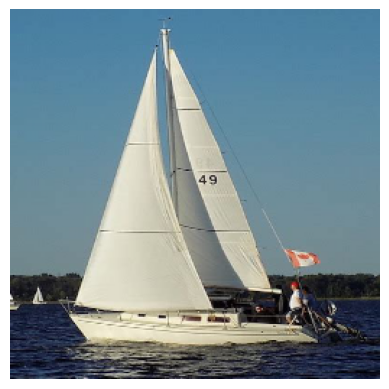

sailboat


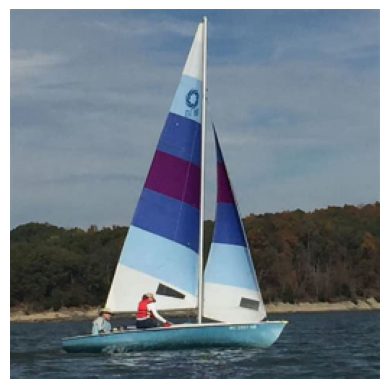

motor_yacht


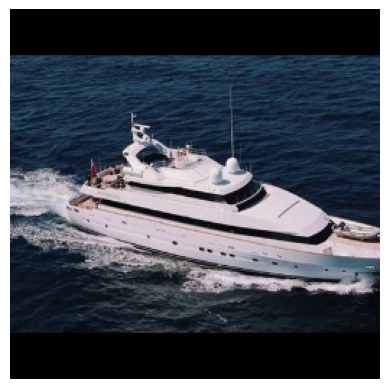

sailboat


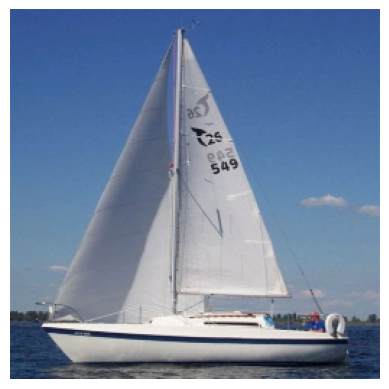

catamaran


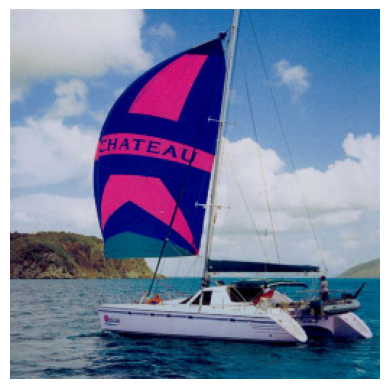

In [14]:
train_boats_large_ds, test_boats_large_ds = \
    random_split(dataset=image_folder_large, lengths=(500, 100))

for i, (X, y) in enumerate(DataLoader(train_boats_large_ds)):
    if i == 6:
        break
    print(int_class_dict[y.argmax().item()])
    plot_image(X.squeeze(0))

In [15]:
# get xception
import pretrainedmodels

In [16]:
print(list(filter(lambda x: 'ception' in x, pretrainedmodels.model_names)))

['bninception', 'inceptionv4', 'inceptionresnetv2', 'inceptionv3', 'xception']


In [239]:
# to fix ssl error

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [17]:
xception_model = pretrainedmodels.xception(num_classes=1000, pretrained='imagenet')
xception_model.requires_grad_(False)
xception_model.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

```
(conv4): SeparableConv2d(
    (conv1): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
    (pointwise): Conv2d(1536, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (bn4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (last_linear): Linear(in_features=2048, out_features=1000, bias=True)```

In [237]:
print(pretrainedmodels.pretrained_settings['xception'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1000, 'scale': 0.8975}}


In [245]:
list(xception_model.children())[-2]

BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [244]:
list(xception_model.children())[-1]

Linear(in_features=2048, out_features=1000, bias=True)

In [18]:
xception_gap = nn.Sequential(
    *list(xception_model.children())[:-1],
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(in_features=2048, out_features=3),
    nn.Softmax(dim=1)
)

In [249]:
for p in xception_gap.parameters():
    if p.requires_grad:
        print(p)

Parameter containing:
tensor([[ 1.7146e-02,  1.2270e-02, -7.4638e-03,  ..., -2.6096e-03,
          9.1229e-03, -8.6365e-03],
        [ 6.0175e-05,  2.2262e-03, -4.2092e-03,  ..., -1.3191e-02,
         -3.9781e-03,  7.7368e-04],
        [ 1.2751e-02,  1.5281e-02,  1.0405e-02,  ..., -9.6649e-03,
         -1.7386e-02, -3.7701e-03]], requires_grad=True)
Parameter containing:
tensor([0.0180, 0.0163, 0.0006], requires_grad=True)


In [250]:
# model_tl_xception
trainer_tl_xception = Trainer(
    model=xception_gap,
    train_ds=train_boats_large_ds,
    val_ds=test_boats_large_ds,
    lr=0.001,
    momentum=0.9)
n_epochs = 60

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_tl_xception.train_step()
    avg_val_loss, avg_val_acc = trainer_tl_xception.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.310 loss: 1.115 train_time: 6.54 s
Val | acc: 0.270 loss: 1.095
================ epoch 010 ================
Train | acc: 0.592 loss: 1.015 train_time: 6.22 s
Val | acc: 0.600 loss: 1.011
================ epoch 020 ================
Train | acc: 0.686 loss: 0.935 train_time: 6.28 s
Val | acc: 0.670 loss: 0.947
================ epoch 030 ================
Train | acc: 0.792 loss: 0.888 train_time: 6.64 s
Val | acc: 0.680 loss: 0.910
================ epoch 040 ================
Train | acc: 0.782 loss: 0.856 train_time: 6.36 s
Val | acc: 0.760 loss: 0.876
================ epoch 050 ================
Train | acc: 0.836 loss: 0.832 train_time: 6.35 s
Val | acc: 0.790 loss: 0.853
================ training ended ================
Train | acc: 0.832 loss: 0.820 train_time: 6.73 s
Val | acc: 0.800 loss: 0.836


Saving figure model_stats_tl_xception


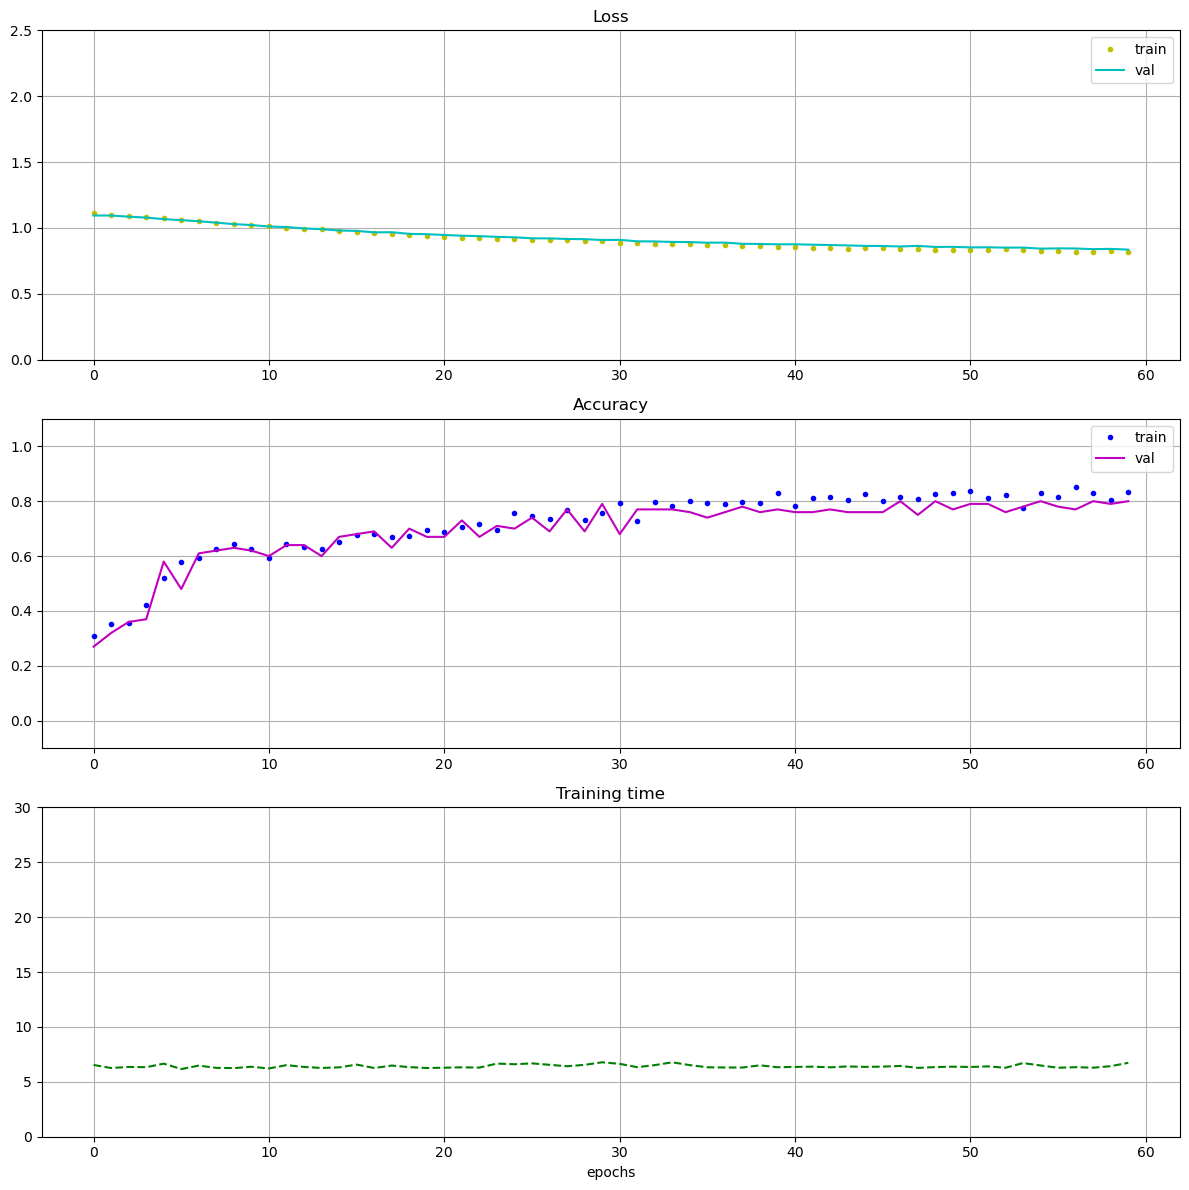

In [251]:
plot_train_stats(*trainer_tl_xception.get_loss_acc_time_history(), fig_id='model_stats_tl_xception')

In [252]:
torch.save(trainer_tl_xception.model.state_dict(),
           Path.cwd() / 'models' / 'model_tl_xception.pt')

In [253]:
example_large_X, example_large_y = next(iter(DataLoader(test_boats_large_ds)))

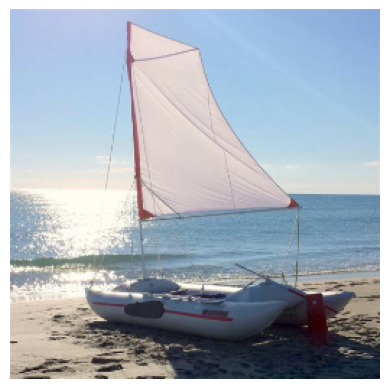

In [255]:
plot_image(example_large_X.squeeze(0))

In [258]:
int_class_dict[example_large_y.squeeze().argmax().item()]

'catamaran'

In [263]:
res = trainer_tl_xception.model(example_large_X.to('cuda'))
res

tensor([[0.4124, 0.1942, 0.3934]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [264]:
int_class_dict[res.squeeze().argmax().item()]

'catamaran'

**fine-tuning**

In [19]:
trainer_tl_xception_state_dict = torch.load(Path.cwd() / 'models' / 'model_tl_xception.pt')

In [20]:
xception_gap_fine_tuned = nn.Sequential(
    *list(xception_model.children())[:-1],
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(in_features=2048, out_features=3),
    nn.Softmax(dim=1)
)
xception_gap_fine_tuned.load_state_dict(trainer_tl_xception_state_dict)
xception_gap_fine_tuned.eval()
None

In [21]:
for p in xception_gap_fine_tuned.parameters():
    p.requires_grad = True

In [23]:
for module in xception_gap_fine_tuned.modules():
    if isinstance(module, nn.BatchNorm2d):
        print(module)
        print(module.state_dict())
        print('='*40)
        for param in module.parameters():
            print(param.requires_grad)
            # param.requires_grad = False
        break

BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
OrderedDict([('weight', tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])), ('bias', tensor([ 0.4076, -0.9851, -0.8652, -0.6365,  0.9313,  0.1432, -0.6618, -1.5135,
        -0.9726,  0.8591,  2.7993,  3.5227,  2.1063,  1.3347, -1.2142, -1.2376,
        -1.6325,  2.8402,  0.1707,  0.7559, -1.5426, -1.0320, -1.0711,  3.3483,
        -0.5304, -1.4475, -1.1696, -1.4443, -1.6129,  2.8850,  2.0640,  0.4750])), ('running_mean', tensor([ 0.5574,  0.6762, -0.7963, -0.6133,  0.0410,  0.3192,  0.2329,  0.7181,
         0.7715, -0.7143,  1.1071, -1.0389, -1.2138,  1.1120, -0.7427, -0.0519,
         0.5292, -0.9791,  0.2514,  0.0123,  0.8000, -0.2843, -1.6695, -1.1962,
         0.4763, -0.7388, -0.4096,  0.3915,  0.6805,  0.9624,  1.4354,  0.7252])), ('running_var', tensor([0.2415, 0.0900, 0.1749, 0.0705, 0.2068, 0.2613, 0.164

In [22]:
# model_tl_xception_fine_tuned
trainer_tl_xception_fine_tuned = Trainer(
    model=xception_gap_fine_tuned,
    train_ds=train_boats_large_ds,
    val_ds=test_boats_large_ds,
    lr=0.0001,
    momentum=0.9,
    batch_size=5
)
n_epochs = 20

for i, epoch in enumerate(range(n_epochs)):
    avg_train_loss, avg_train_acc, epoch_train_time = trainer_tl_xception_fine_tuned.train_step()
    avg_val_loss, avg_val_acc = trainer_tl_xception_fine_tuned.val_step()
    if i % 10 == 0:
        print('='*16 + f" epoch {i:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")
print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.3f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.3f}")

================ epoch 000 ================
Train | acc: 0.748 loss: 0.876 train_time: 18.18 s
Val | acc: 0.830 loss: 0.791
================ epoch 010 ================
Train | acc: 0.774 loss: 0.813 train_time: 14.95 s
Val | acc: 0.860 loss: 0.731
================ training ended ================
Train | acc: 0.844 loss: 0.746 train_time: 14.88 s
Val | acc: 0.860 loss: 0.710


In [26]:
torch.cuda.empty_cache()

Saving figure model_stats_tl_xception_fine_tuned


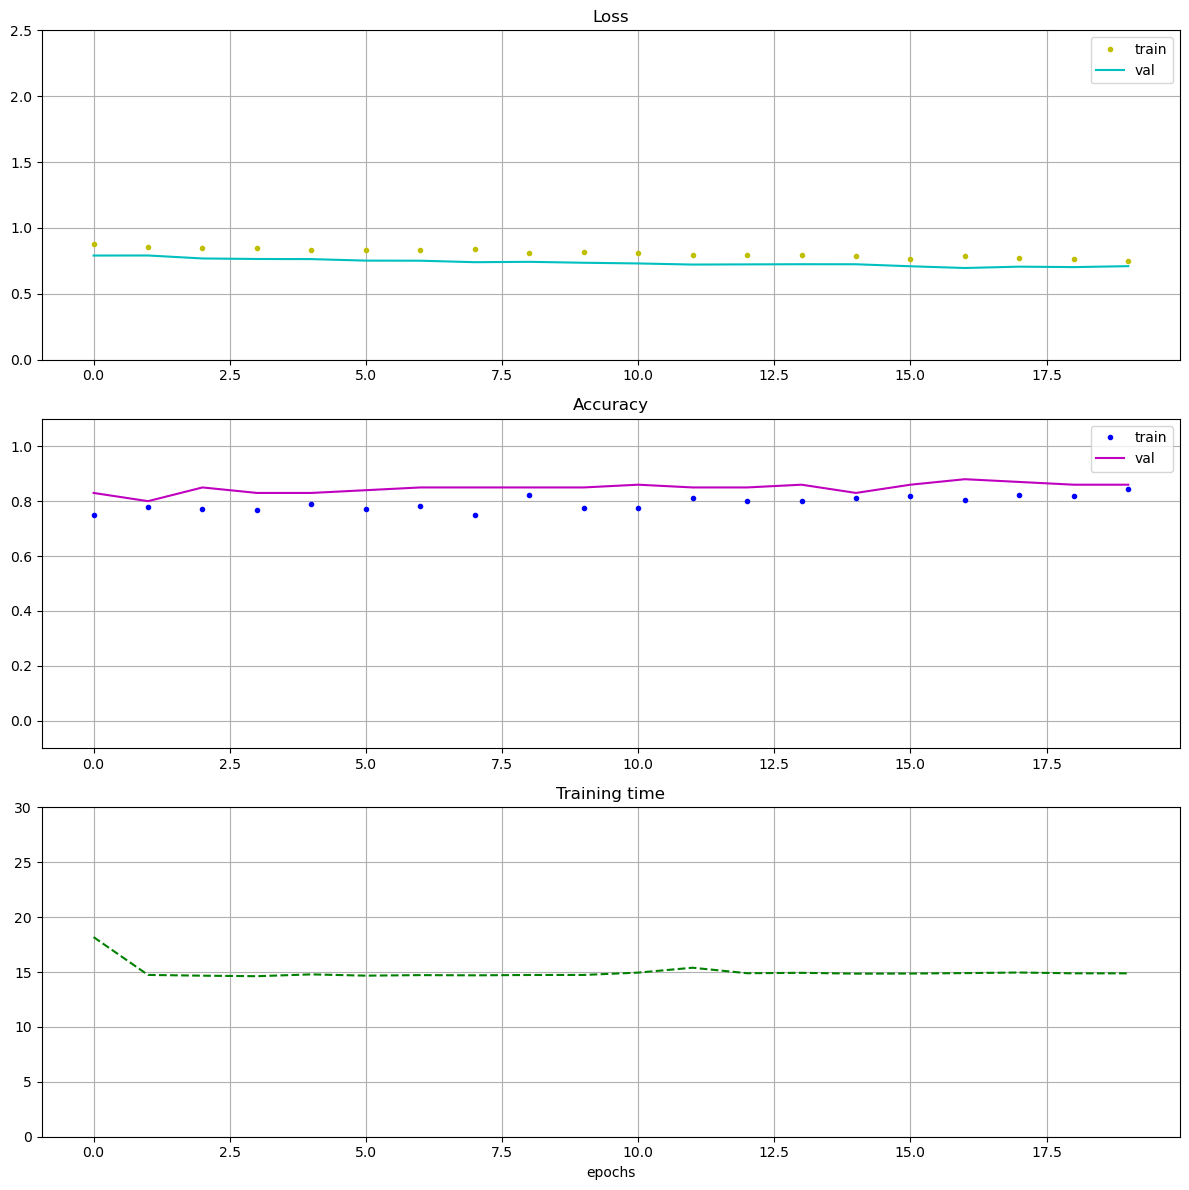

In [23]:
plot_train_stats(*trainer_tl_xception_fine_tuned.get_loss_acc_time_history(), 
                 fig_id='model_stats_tl_xception_fine_tuned')

In [24]:
torch.save(trainer_tl_xception_fine_tuned.model.state_dict(),
           Path.cwd() / 'models' / 'trainer_tl_xception_fine_tuned.pt')

# No dobra, ale w sumie na jakiej podstawie taka sieć podejmuje decyzje?

Kompleksowa odpowiedź na to pytanie wymaga zaznajomienia się z całą dyscypliną naukową,
jaką jest badanie interpretowalności modeli decyzyjnych. W tym przypadku zadowolimy się
bardziej zgrubnym zrozumieniem tego co się dzieje, w sprytny sposób wykorzystując naturę
warstwy GAP.

6. Przygotujmy kilka-kilkanaście fotografii, które nasza sieć klasyfikuje poprawnie. Najlepiej, jeżeli będą mieć różnorodną zawartość.

In [18]:
xception_fine_tuned = nn.Sequential(
    *list(xception_model.children())[:-1],
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(in_features=2048, out_features=3),
    nn.Softmax(dim=1)
)
xception_fine_tuned.load_state_dict(torch.load(
    Path.cwd() / 'models' / 'trainer_tl_xception_fine_tuned.pt'
))
xception_fine_tuned.eval()
None

In [19]:
test_images = [(X, y) for X, y in DataLoader(test_boats_large_ds)]

In [ ]:
xception_fine_tuned

motor_yacht


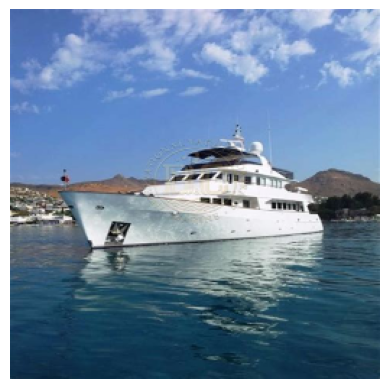

In [74]:
print(int_class_dict[test_images[24][1].squeeze().argmax().item()])
plot_image(test_images[24][0].squeeze())

In [61]:
example_images = []
...

In [62]:
example_images.append(test_images[2])

In [63]:
example_images.append(test_images[6])

In [64]:
example_images.append(test_images[9])

In [65]:
example_images.append(test_images[12])

In [66]:
example_images.append(test_images[18])

In [75]:
example_images.append(test_images[24])

In [76]:
len(example_images)

6

motor_yacht
Predicted: tensor([4.6593e-03, 9.9527e-01, 6.8060e-05], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Predicted: motor_yacht


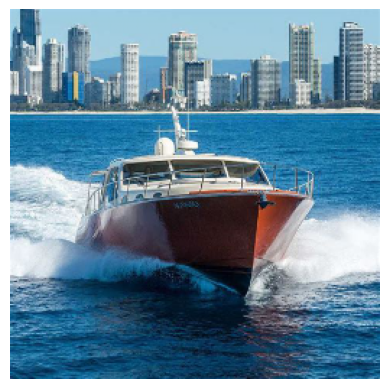

sailboat
Predicted: tensor([0.1122, 0.0213, 0.8665], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted: sailboat


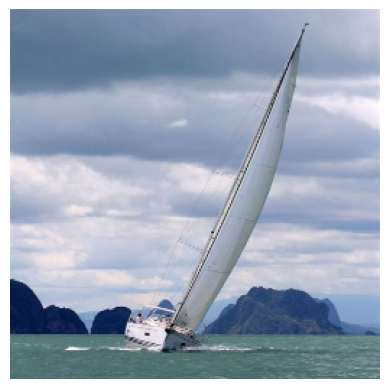

catamaran
Predicted: tensor([0.9917, 0.0029, 0.0054], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted: catamaran


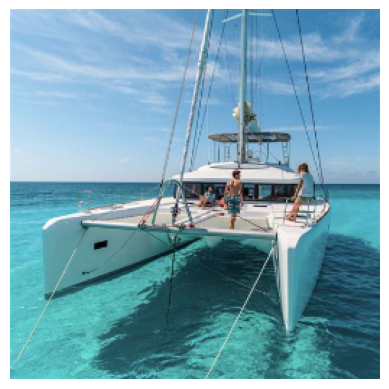

sailboat
Predicted: tensor([6.9779e-03, 7.7209e-05, 9.9295e-01], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Predicted: sailboat


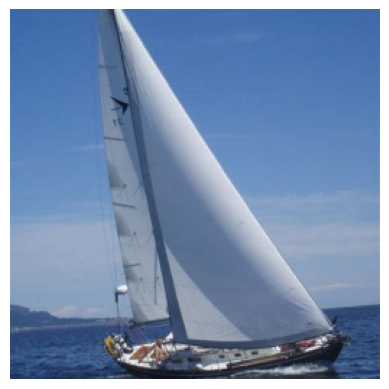

catamaran
Predicted: tensor([0.9321, 0.0180, 0.0500], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted: catamaran


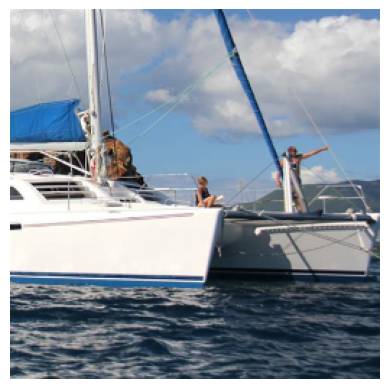

motor_yacht
Predicted: tensor([0.0016, 0.9969, 0.0015], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted: motor_yacht


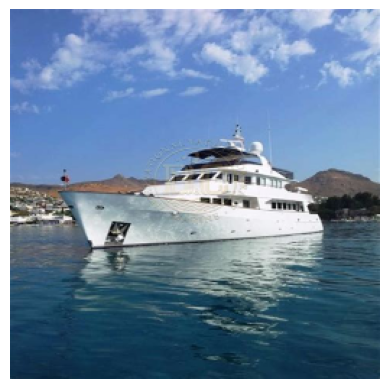

In [77]:

for X, y in example_images:
    print(int_class_dict[y.squeeze().argmax().item()])
    pred = xception_fine_tuned(X.to('cuda')).squeeze()
    print(f"Predicted: {pred}")
    print(f"Predicted: {int_class_dict[pred.argmax().item()]}")
    plot_image(X.squeeze())

In [78]:
example_motor_yacht = example_images[0]
example_my_X, example_my_y = example_motor_yacht

7. Dla pierwszej z nich wykonajmy poniższe kroki.
    1. Przyjrzyjmy się bezpośrednio temu, co zwraca wykorzystywana sieć bazowa Xception. Jeżeli z wymiarami wszystko poszło zgodnie z planem, to powinny być to tensory zawierające 2048 kanałów, każdy z nich o rozdzielczości 8x8.
        1. Podaj na wejście sieci wybraną fotografię i podejrzyj zawartości kilku-kilkunastu z tych 2048 kanałów. Jak wyglądają ich aktywacje? [🖼️]
    2. Kanały te można zsumować wagowo (wagi pochodzą z końcowych neuronów aktywacyjnych). Taka suma tworzy prostą mapkę, która pokazuje jak duży był wpływ danego obszaru zdjęcia na finalną klasyfikację. [⌨️]
        1. Czyli w praktyce: [zawartość kanału 0 przed GAP] * [waga związana z kanałem 0 w tym neuronie ostatniej warstwy gęsto połączonej, który zapalił się najmocniej (który odpowiada za tę klasę, do której została przydzielona fotografia)] + [zawartość kanału 1 przed GAP] * [waga związana z kanałem 1 w tym neuronie ostatniej warstwy gęsto połączonej, który zapalił się najmocniej] + ... (i tak dla wszystkich 2048) .
        2. To samo, ale jeszcze krócej: mnożymy zawartość kanałów przed GAPem przez odpowiadające im współczynniki w wybranym neuronie wyjściowym i sumujemy uzyskane wyniki w jeden kanał.
    3. Obejrzyj uzyskaną heatmapę. Jak ma się do tego, co znajduje się na fotografii?
8. Wykonaj w ten sam sposób heatmapy dla wszystkich wybranych obrazów. Porównaj obszary na których koncentrowała się sieć z ich rzeczywistą zawartością. [🖼️]

In [80]:
xception_fine_tuned(example_my_X.to('cuda'))

tensor([[4.6593e-03, 9.9527e-01, 6.8060e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [125]:
xception_fine_tuned(example_my_X.to('cuda')).squeeze().argmax().item()

1

In [82]:
print(len(list(xception_fine_tuned.children())))

25


In [108]:
print(*list(xception_fine_tuned.children())[-1:])

Softmax(dim=1)


In [87]:
xception_fine_tuned_before_gap = nn.Sequential(
    *list(xception_fine_tuned.children())[:-4]
)

In [88]:
example_res_before_gap = xception_fine_tuned_before_gap(example_my_X.to('cuda'))

In [92]:
example_res_before_gap.shape

torch.Size([1, 2048, 8, 8])

Saving figure before_gap_act_0_0


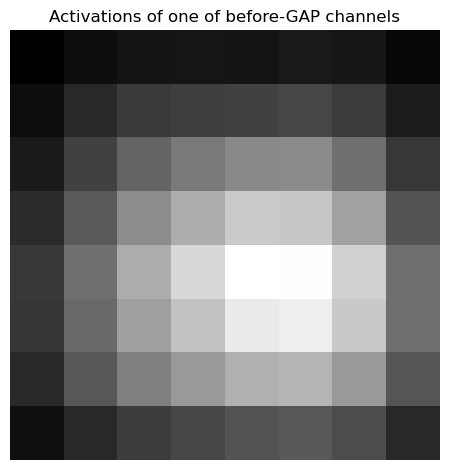

In [94]:
plot_image(example_res_before_gap.squeeze()[0].to('cpu'), 
           title='Activations of one of before-GAP channels', 
           save=True, fig_id='before_gap_act_0_0')

Saving figure before_gap_act_0_1


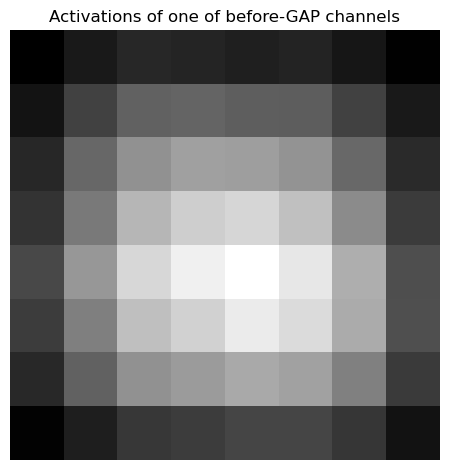

In [106]:
plot_image(example_res_before_gap.squeeze()[589].to('cpu'), 
           title='Activations of one of before-GAP channels', 
           save=True, fig_id='before_gap_act_0_1')

Saving figure before_gap_act_0_2


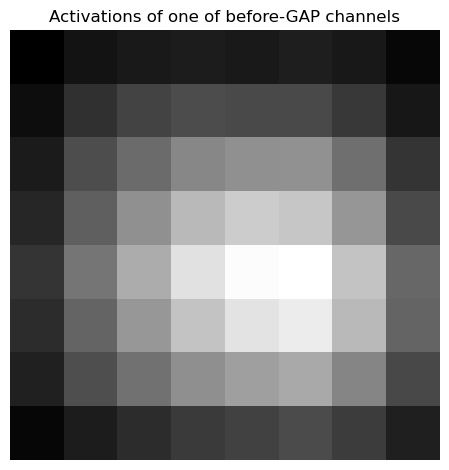

In [105]:
plot_image(example_res_before_gap.squeeze()[1836].to('cpu'), 
           title='Activations of one of before-GAP channels', 
           save=True, fig_id='before_gap_act_0_2')

In [123]:
list(xception_fine_tuned_before_softmax.children())[-3]

AdaptiveAvgPool2d(output_size=(1, 1))

In [126]:
list(list(xception_fine_tuned_before_softmax.children())[-1].parameters())[0][0].shape

torch.Size([2048])

In [116]:
for p in :
    print(p)

Parameter containing:
tensor([[ 0.0172,  0.0439,  0.0006,  ..., -0.0198, -0.0055, -0.0111],
        [ 0.0014, -0.0115,  0.0020,  ...,  0.0184, -0.0071, -0.0029],
        [ 0.0113, -0.0026, -0.0038,  ..., -0.0241,  0.0003,  0.0024]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0634,  0.0121, -0.0406], device='cuda:0', requires_grad=True)


In [224]:
def get_influence_map(image: tuple[torch.Tensor, torch.Tensor], model=xception_fine_tuned) -> torch.Tensor:
    xception_fine_tuned_before_gap = nn.Sequential(
        *list(model.children())[:-4])
    
    xception_fine_tuned_before_softmax = nn.Sequential(
        *list(model.children())[:-1])
    
    X = image[0]
    res_before_gap = xception_fine_tuned_before_gap(X.to('cuda')).to('cpu')
    res_before_softmax = xception_fine_tuned_before_softmax(X.to('cuda')).to('cpu')
    
    class_int = model(X.to('cuda')).squeeze().argmax().item()
    last_layer_weights = list(list(xception_fine_tuned_before_softmax.children())[-1].parameters())[0]
    last_layer_weights_for_class = last_layer_weights[class_int].unsqueeze(1).unsqueeze(2)
    
    return torch.sum(res_before_gap.squeeze() * last_layer_weights_for_class.to('cpu'), 
                     dim=0).to('cpu')

In [154]:
get_influence_map(example_motor_yacht)

tensor([[-2.3272, -1.2126, -0.3022,  0.0905,  0.2610,  0.0517, -0.5929, -1.8632],
        [-1.6401,  0.3868,  2.0877,  3.0879,  3.5610,  3.1122,  1.8920, -0.5961],
        [-0.3392,  3.2610,  6.0934,  8.4051,  9.0217,  8.1772,  5.4520,  1.2134],
        [ 0.4960,  4.8115,  8.2323, 11.3488, 12.3904, 11.6574,  8.3254,  2.9205],
        [ 1.7410,  6.9613, 10.9810, 14.7784, 15.8755, 15.0822, 10.7594,  4.3803],
        [ 1.4326,  5.8504,  9.3448, 12.3767, 13.7221, 13.5875, 10.1990,  4.3805],
        [ 0.4426,  3.8155,  6.5250,  8.5548,  9.4507,  9.2702,  6.7523,  2.4589],
        [-1.4735,  0.1107,  1.4596,  2.2556,  2.8326,  2.9884,  2.0007, -0.1664]],
       grad_fn=<SumBackward1>)

Saving figure example_a


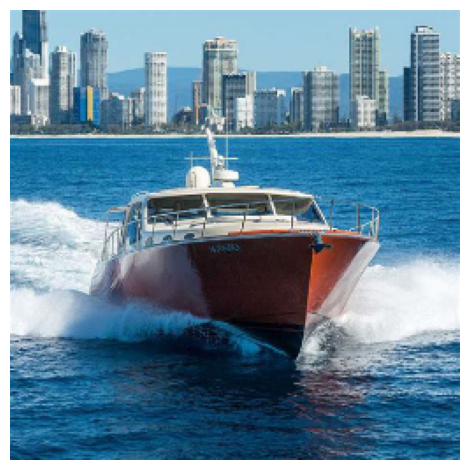

In [160]:
plot_image(example_motor_yacht[0].squeeze(),
           save=True, fig_id='example_a')

Saving figure example_a_inf_map


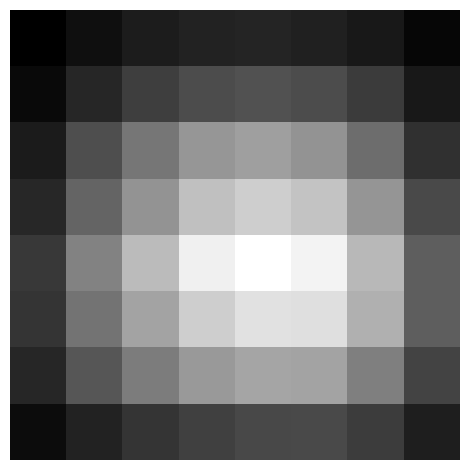

In [161]:
plot_image(get_influence_map(example_motor_yacht),
           save=True, fig_id='example_a_inf_map')

True class: motor_yacht
Predicted probs: tensor([4.6593e-03, 9.9527e-01, 6.8060e-05], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Predicted class: motor_yacht
Saving figure example_a


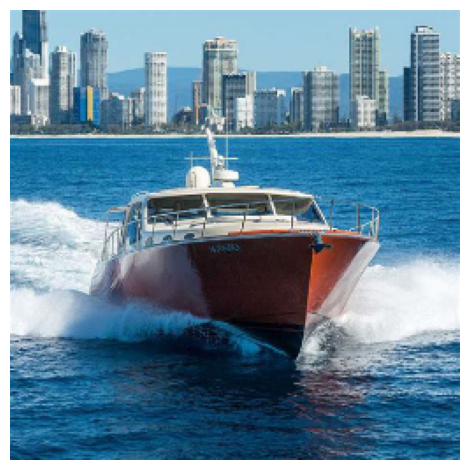

Saving figure example_a_inf_map


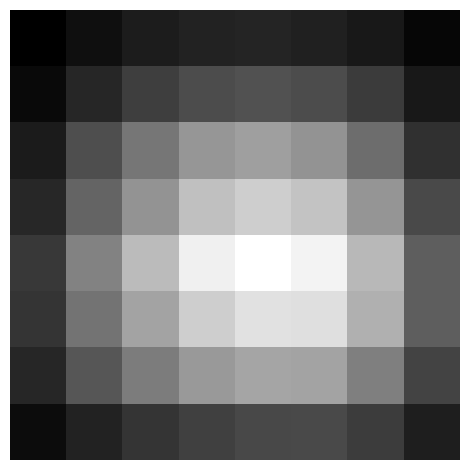

True class: sailboat
Predicted probs: tensor([0.1122, 0.0213, 0.8665], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted class: sailboat
Saving figure example_b


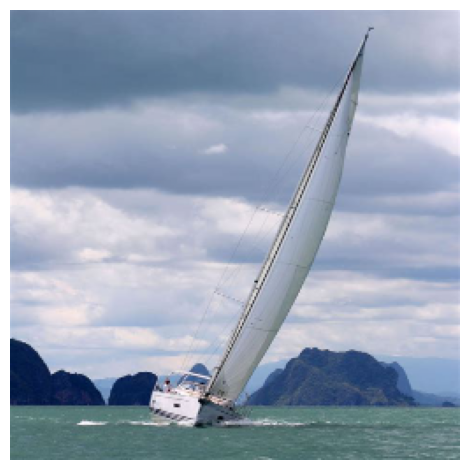

Saving figure example_b_inf_map


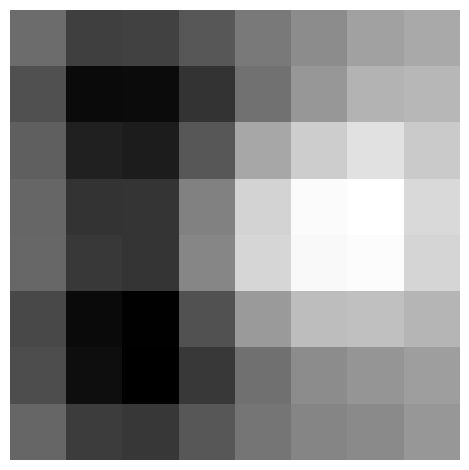

True class: catamaran
Predicted probs: tensor([0.9917, 0.0029, 0.0054], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted class: catamaran
Saving figure example_c


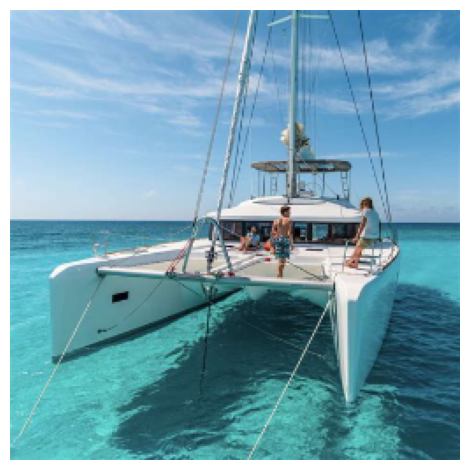

Saving figure example_c_inf_map


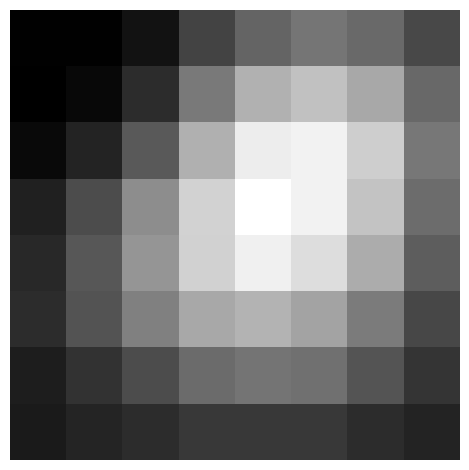

True class: sailboat
Predicted probs: tensor([6.9779e-03, 7.7209e-05, 9.9295e-01], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Predicted class: sailboat
Saving figure example_d


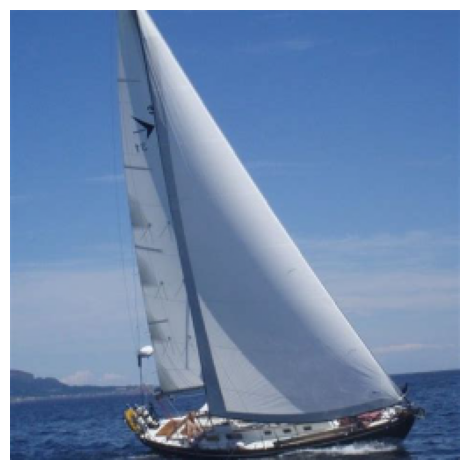

Saving figure example_d_inf_map


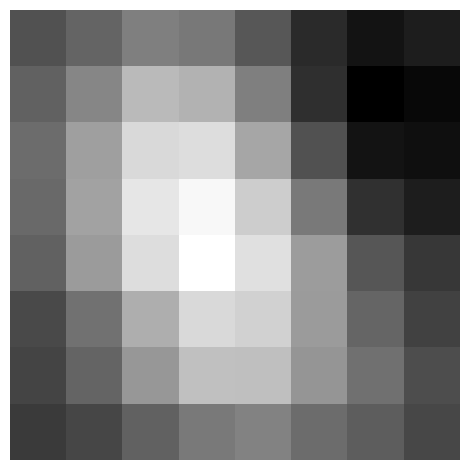

True class: catamaran
Predicted probs: tensor([0.9321, 0.0180, 0.0500], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted class: catamaran
Saving figure example_e


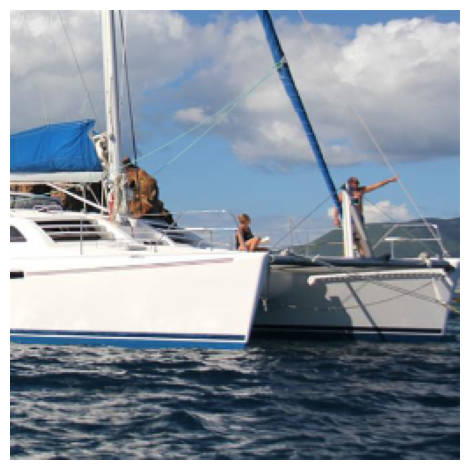

Saving figure example_e_inf_map


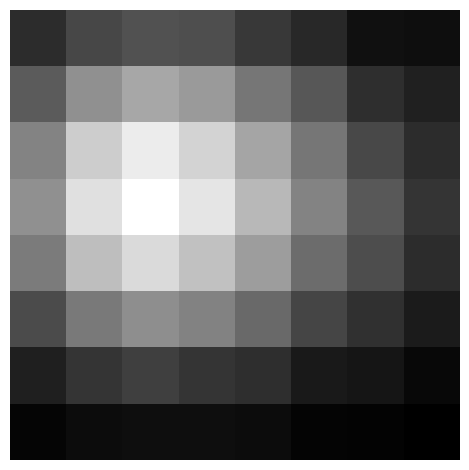

True class: motor_yacht
Predicted probs: tensor([0.0016, 0.9969, 0.0015], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted class: motor_yacht
Saving figure example_f


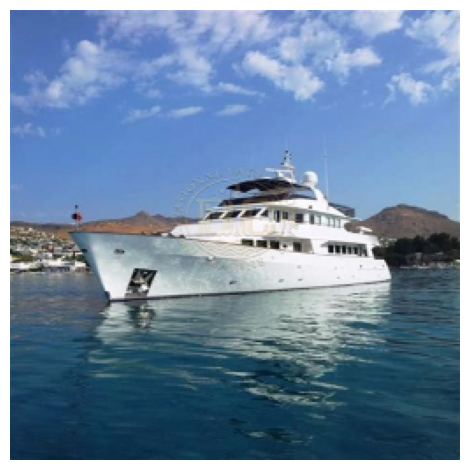

Saving figure example_f_inf_map


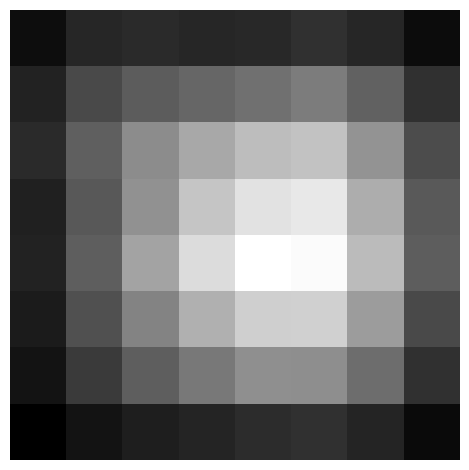

In [165]:
letters = 'a b c d e f'.split()

for i, (X, y) in enumerate(example_images):
    print(f'True class: {int_class_dict[y.squeeze().argmax().item()]}')
    pred = xception_fine_tuned(X.to('cuda')).squeeze()
    print(f"Predicted probs: {pred}")
    print(f"Predicted class: {int_class_dict[pred.argmax().item()]}")
    plot_image(X.squeeze(), save=True, fig_id=f'example_{letters[i]}')
    plot_image(get_influence_map((X, y)), save=True, fig_id=f'example_{letters[i]}_inf_map')

9. Poszukajmy tych obrazów, dla których nasza sieć się myli.
    1. Wyplotujmy kilka-kilkanaście z nich. Czy to typowe elementy danej klasy? Czy człowiek mógłby je prawidłowo rozpoznać? [🖼️]
    2. Dla tych obrazów również przygotuj oparte o GAP heatmapy istotności. Czy pomagają w zrozumieniu, na jakiej podstawie sieć zachowała się w błędny sposób? [🖼️]

sailboat


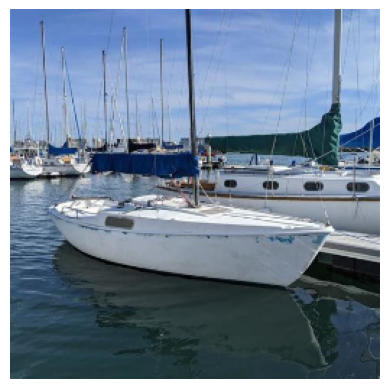

Predicted: tensor([0.4294, 0.3503, 0.2203], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted: catamaran


In [215]:
idx = 55

print(int_class_dict[test_images[idx][1].squeeze().argmax().item()])
plot_image(test_images[idx][0].squeeze())
pred = xception_fine_tuned(test_images[idx][0].to('cuda')).squeeze()
print(f"Predicted: {pred}")
print(f"Predicted: {int_class_dict[pred.argmax().item()]}")

In [218]:
incorrect_images = []

In [219]:
incorrect_images.append(test_images[32])

In [220]:
incorrect_images.append(test_images[39])

In [209]:
# incorrect_images.append(test_images[50])

In [221]:
incorrect_images.append(test_images[55])

catamaran
Predicted: tensor([0.1780, 0.0149, 0.8071], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted: sailboat


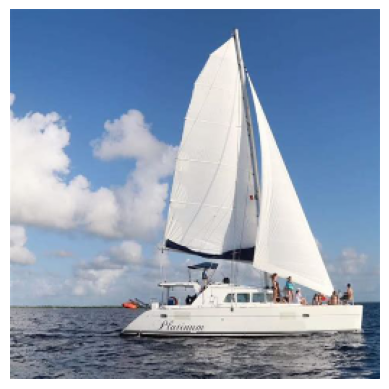

catamaran
Predicted: tensor([0.0803, 0.9145, 0.0051], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted: motor_yacht


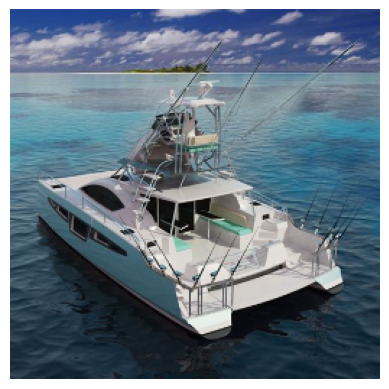

sailboat
Predicted: tensor([0.4294, 0.3503, 0.2203], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted: catamaran


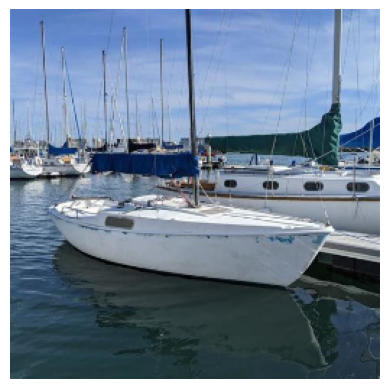

In [222]:

for X, y in incorrect_images:
    print(int_class_dict[y.squeeze().argmax().item()])
    pred = xception_fine_tuned(X.to('cuda')).squeeze()
    print(f"Predicted: {pred}")
    print(f"Predicted: {int_class_dict[pred.argmax().item()]}")
    plot_image(X.squeeze())

True class: catamaran
Predicted probs: tensor([0.1780, 0.0149, 0.8071], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted class: sailboat
Saving figure example_incorrect_a


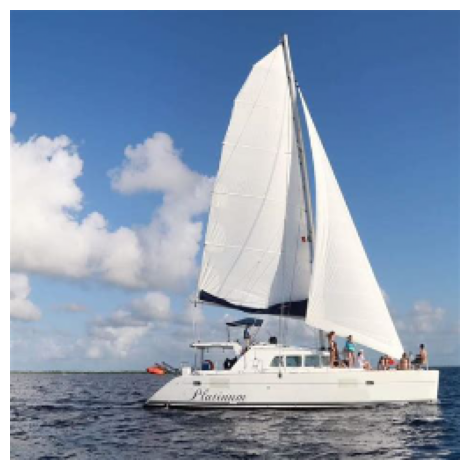

Saving figure example_incorrect_a_inf_map


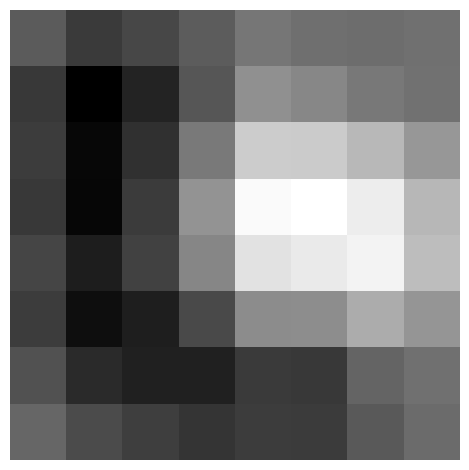

True class: catamaran
Predicted probs: tensor([0.0803, 0.9145, 0.0051], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted class: motor_yacht
Saving figure example_incorrect_b


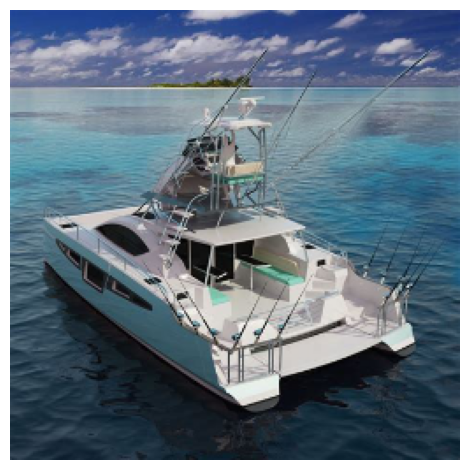

Saving figure example_incorrect_b_inf_map


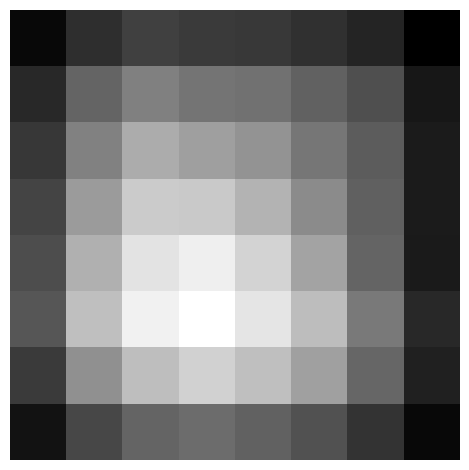

True class: sailboat
Predicted probs: tensor([0.4294, 0.3503, 0.2203], device='cuda:0', grad_fn=<SqueezeBackward0>)
Predicted class: catamaran
Saving figure example_incorrect_c


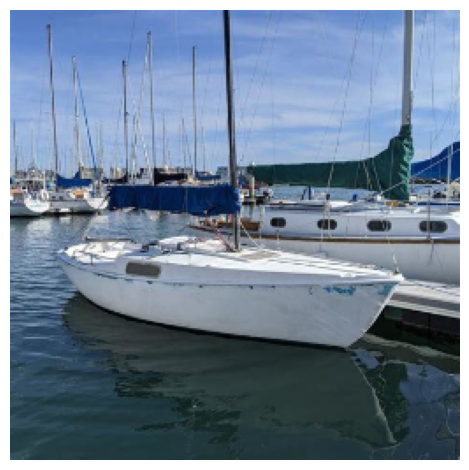

Saving figure example_incorrect_c_inf_map


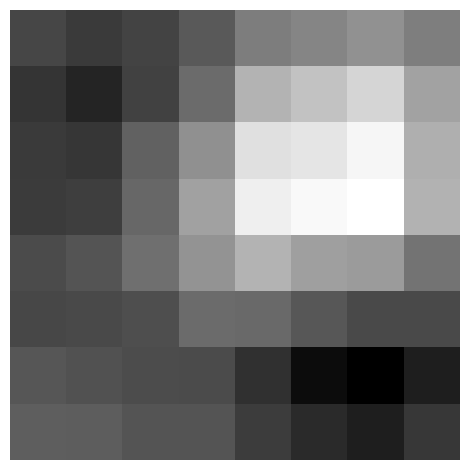

In [223]:
letters = 'a b c d e f'.split()

for i, (X, y) in enumerate(incorrect_images):
    print(f'True class: {int_class_dict[y.squeeze().argmax().item()]}')
    pred = xception_fine_tuned(X.to('cuda')).squeeze()
    print(f"Predicted probs: {pred}")
    print(f"Predicted class: {int_class_dict[pred.argmax().item()]}")
    plot_image(X.squeeze(), save=True, fig_id=f'example_incorrect_{letters[i]}')
    plot_image(get_influence_map((X, y)), save=True, fig_id=f'example_incorrect_{letters[i]}_inf_map')